<a href="https://drive.google.com/file/d/1b7tSyJBpWggHEBGdWa80JdKh7VNq2FEf/view?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Problem 1
Implement serial test and apply to a `samples`

In [4]:
def rng(m=2**32, a=1103515245, c=12345):
    rng.current = (a * rng.current + c) % m
    return rng.current / m
rng.current = 1
samples = [rng() for _ in range(1000)]


import numpy as np
import scipy.stats as stats

def serial_test(sample, m=2):
  #вычисляем кол-во точек
  n = len(sample) // m
  #обозначаем точки
  tuples = [tuple(sample[i*m:(i+1)*m]) for i in range(n)]

  #считаем кол-во каждой уникальной точки
  unique_tuples, counts = np.unique(tuples, axis=0, return_counts=True)
  observed = counts
  #вычисляем частоту появления каждой точки, если распределение равномерное
  expected = np.full_like(observed, n / len(unique_tuples), dtype=float)

  #применяем критерий хи-квадрат
  chi2_stat, p_value = stats.chisquare(observed, expected)
  return chi2_stat, p_value

chi2_stat, p_value = serial_test(samples, m=2)
print(f"Chi-square statistic: {chi2_stat}, p-value: {p_value}")

Chi-square statistic: 0.0, p-value: 1.0


### Problem 2*
Implement permutation test and apply to a `samples`

In [5]:
import itertools

def permutation_test(samples, d):
    #разбиваем выборку на возможное кол-во блоков
    n = len(samples) // d
    truncated_samples = samples[:n * d]
    chunks = [truncated_samples[i*d : (i+1)*d] for i in range(n)]

    #генерируем возможные перестановки для d элементов
    possible_perms = list(itertools.permutations(range(d)))
    #вычисляем ожидаемое кол-во каждой перестановки
    expected_count = n / len(possible_perms)

    #создаем словарь, где ключ - перестановка, значение - кол-во ее вхождений
    counts = {perm: 0 for perm in possible_perms}
    for chunk in chunks:
        #получаем перестановку
        perm = tuple(sorted(range(d), key=lambda i: chunk[i]))
        #увеличиваем ее кол-во
        counts[perm] += 1

    observed = list(counts.values())
    chi2_stat, p_value = stats.chisquare(observed, [expected_count] * len(observed))

    return chi2_stat, p_value

chi2_stat, p_value = permutation_test(samples, d=2)
print(f"Chi-squared statistic: {chi2_stat}")
print(f"P-value: {p_value}")

Chi-squared statistic: 0.032
P-value: 0.8580276569875211


### Problem 3

Provide a statistical test to show that `rng_bad` has problems but `rng_good` does not.

In [6]:
#используем реализованный выше permutation_test
def rng_bad(m=2**31, a=65539, c=0):
    rng_bad.current = (a * rng_bad.current + c) % m
    return rng_bad.current / m
rng_bad.current = 1

def rng_good(m=2**32, a=1103515245, c=12345):
    rng_good.current = (a * rng_good.current + c) % m
    return rng_good.current / m
rng_good.current = 1

n_samples = 10000000  # Больше данных для надежности теста
samples_bad = [rng_bad() for _ in range(n_samples)]
samples_good = [rng_good() for _ in range(n_samples)]

d = 3
chi2_bad, p_bad = permutation_test(samples_bad, d)
chi2_good, p_good = permutation_test(samples_good, d)

print(f"  Chi2_bad: {chi2_bad:.2f}, p-value_bad: {p_bad:.10f}")
print(f"  Chi2_good: {chi2_good:.2f}, p-value_good: {p_good:.10f}")

  Chi2_bad: 7.72, p-value_bad: 0.1721630160
  Chi2_good: 1.53, p-value_good: 0.9094164189


### Problem 4
Simulate a sample of 1000 from a discrete distribution on a set of digits $0, 1, 2, \ldots, 9$ with weights $0.12, 0.3, 0.167, 0.24, 0.31, 0.54, 0.111, 0.02, 0.001, 0.2$. Construct a histogram from the sample. Optimise the algorithm by ordering the weights.

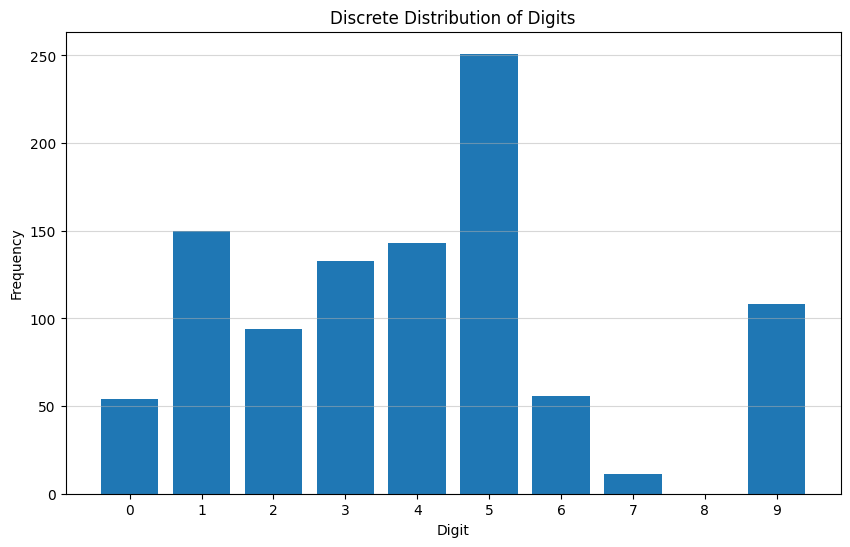

In [7]:
import matplotlib.pyplot as plt

#определяем веса
digits = np.arange(10)
weights = [0.12, 0.3, 0.167, 0.24, 0.31, 0.54, 0.111, 0.02, 0.001, 0.2]
#нормализуем их
weights = np.array(weights)
normalized_weights = weights / weights.sum()

#генерируем выборку
np.random.seed(0)
sample = np.random.choice(digits, size=1000, p=normalized_weights)

plt.figure(figsize=(10, 6))
plt.hist(sample, bins=np.arange(11)-0.5, rwidth=0.8)
plt.xticks(digits)
plt.xlabel('Digit')
plt.ylabel('Frequency')
plt.title('Discrete Distribution of Digits')
plt.grid(axis='y', alpha=0.5)

plt.show()

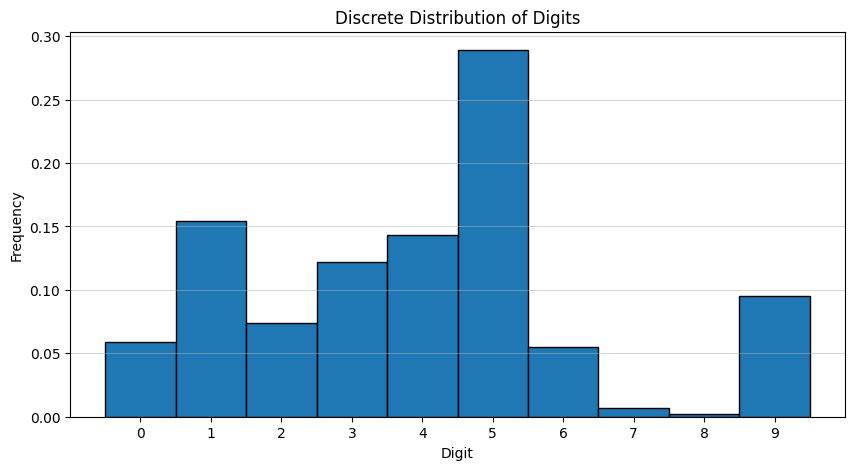

In [20]:
#оптимизированный алгоритм с отсортированными весами
sorted_indices = np.argsort(weights)[::-1]
sorted_digits = digits[sorted_indices]
sorted_weights = weights[sorted_indices]
sorted_weights /= sorted_weights.sum()

sample = np.random.choice(sorted_digits, size=1000, p=sorted_weights)
plt.figure(figsize=(10, 5))
plt.hist(sample, bins=np.arange(11)-0.5, density=True, edgecolor='black')
plt.xticks(digits)
plt.xlabel('Digit')
plt.ylabel('Frequency')
plt.title('Discrete Distribution of Digits')
plt.grid(axis='y', alpha=0.5)
plt.show()

### Problem 5
Simulate a sample of size 1000 from the distribution $\operatorname{Exp}(\lambda)$ using the Inverse transform method. Construct a sample histogram and an accurate plot of the distribution density.

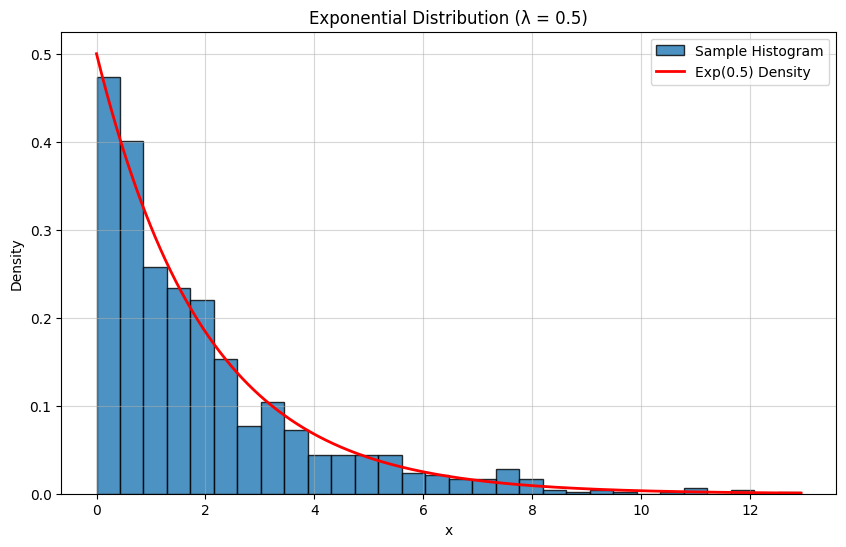

In [8]:
lambda_param = 0.5
sample_size = 1000

np.random.seed(52)
#генерируем выборку
u = np.random.uniform(0, 1, sample_size)
#применяем метод обратного преобразования
sample = -np.log(u) / lambda_param

#создаем гистограмму
plt.figure(figsize=(10, 6))
plt.hist(sample, bins=30, density=True, alpha=0.8, edgecolor='black', label='Sample Histogram')

#создаем линию графика плотности
x = np.linspace(0, np.max(sample), 1000)
density = lambda_param * np.exp(-lambda_param * x)
plt.plot(x, density, 'r-', linewidth=2, label=f'Exp({lambda_param}) Density')

plt.xlabel('x')
plt.ylabel('Density')
plt.title(f'Exponential Distribution (λ = {lambda_param})')
plt.legend()
plt.grid(alpha=0.5)

plt.show()

### Problem 6
Justify (orally) that the accept-reject method really samples from the required distribution. Simulate $1000$ points from the distribution with density $e^xcos^2x \cdot \mathbb{I}_{[-\frac\pi2, \frac\pi2]}$. Plot the sampled histogram on the sample and compare it with the plot of the exact density function.

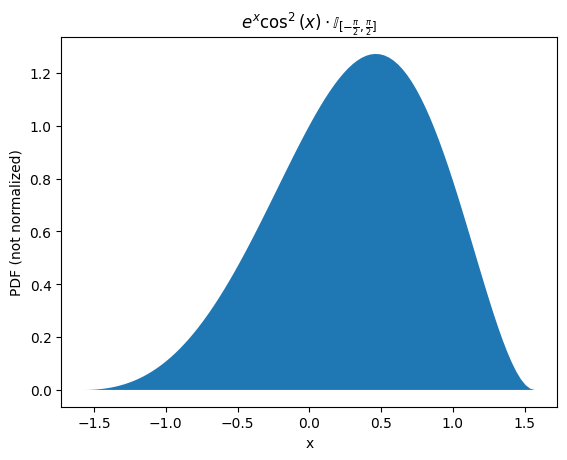

In [ ]:
fig = plt.figure()

x = np.linspace(-np.pi/2, np.pi/2, 100)
density = np.exp(x) * np.cos(x) ** 2 # not normalized density!
plt.fill_between(x, 0, density)
plt.ylabel('PDF (not normalized)')
plt.xlabel('x')
plt.title(r'$e^x \cos^2(x) \cdot \mathbb{I}_{[-\frac{\pi}{2}, \frac{\pi}{2}]}$')

plt.show()

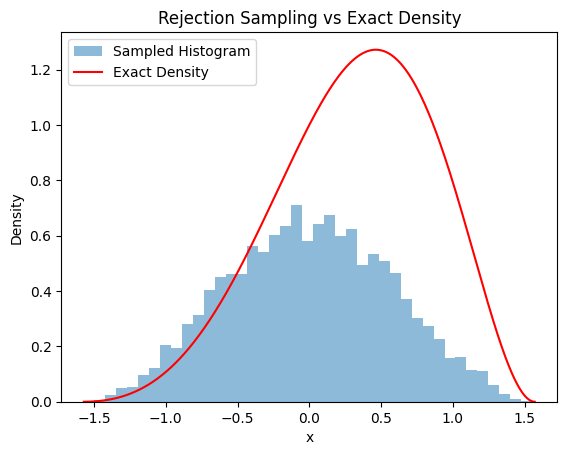

In [9]:
import numpy as np

#функция плотности
def target_density(x):
    return np.exp(x) * (np.cos(x))**2 * ((-np.pi/2 <= x) & (x <= np.pi/2))

#функция плотности вспомогательного распределения
def proposal_density(x):
    return np.exp(x) * ((-np.pi/2 <= x) & (x <= np.pi/2))

#генерируем выборку
def sample_proposal(n):
    return np.random.uniform(-np.pi/2, np.pi/2, n)

#метод отклонения
def rejection_sampling(n):
    samples = []
    while len(samples) < n:
        x = sample_proposal(1)[0]                     # Берём одно случайное число x
        y = np.random.uniform(0, proposal_density(x)) # Генерируем y в [0, p(x)]
        if y < target_density(x):                     #Проверяем, попадает ли точка под кривую π(x)
            samples.append(x)
    return np.array(samples)

n_samples = 5000
samples = rejection_sampling(n_samples)

# построение гистограммы и графика плотности
x_vals = np.linspace(-np.pi/2, np.pi/2, 1000)
plt.hist(samples, bins=40, density=True, alpha=0.5, label='Sampled Histogram')
plt.plot(x_vals, target_density(x_vals), 'r-', label='Exact Density')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.title('Rejection Sampling vs Exact Density')
plt.show()

### Problem 7
Model and depict a sample of 500 points uniformly distributed within a given triangle without using a selection method.

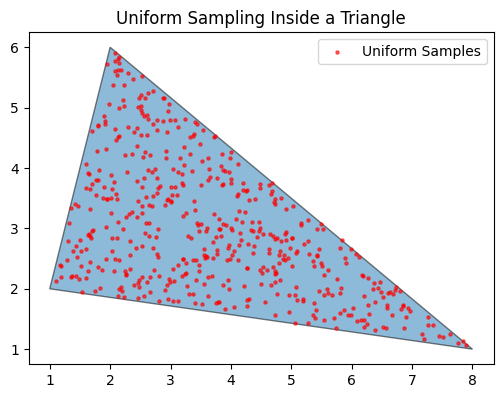

In [10]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

A = np.array([1, 2])
B = np.array([2, 6])
C = np.array([8, 1])

#генерация равномерных точек внутри треугольника
def uniform_sample_triangle(A, B, C, n_samples=500):
    samples = []
    for _ in range(n_samples):
        u, v = np.random.rand(2)   #два случайных числа от 0 до 1
        if u + v > 1:              # Отражение точки, если она вышла за пределы
          u, v = 1 - u, 1 - v
        sample = (1 - u - v) * A + u * B + v * C       # Перевод в декартовы координаты
        samples.append(sample)
    return np.array(samples)

samples = uniform_sample_triangle(A, B, C, 500)

#построение графика
fig, ax = plt.subplots(figsize=(6,6))
polygon = Polygon([A, B, C], closed=True, edgecolor='black', alpha=0.5)
ax.add_patch(polygon)
ax.scatter(samples[:,0], samples[:,1], color='red', s=5, alpha=0.6, label="Uniform Samples")
ax.set_aspect('equal')
plt.legend()
plt.title("Uniform Sampling Inside a Triangle")
plt.show()

### Problem 8
Model without using the selection method a sample of $500$ points uniformly distributed inside the unit circle. Picture the obtained points. Do they really fill the circle uniformly?

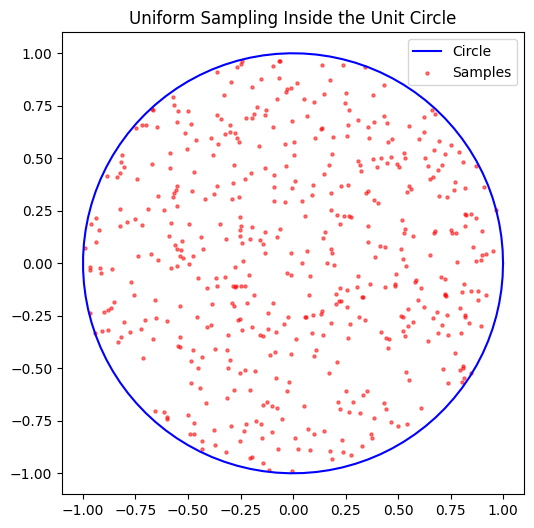

In [11]:
n_samples = 500
theta = np.random.uniform(0, 2*np.pi, n_samples)  #случайный угол
r = np.sqrt(np.random.uniform(0, 1, n_samples))   #случайный скорректированный для равномер распред радиус

#преобразование в декартовы координаты
x = r * np.cos(theta)
y = r * np.sin(theta)

#построение графика
fig, ax = plt.subplots(figsize=(6,6))
t = np.linspace(0, 2*np.pi, 100)
ax.plot(np.cos(t), np.sin(t), 'b-', label="Circle")
ax.scatter(x, y, color='red', s=5, alpha=0.5, label="Samples")
ax.set_aspect('equal')
plt.legend()
plt.title("Uniform Sampling Inside the Unit Circle")
plt.show()

### Problem 9
Prove (orally) that the following algorithm (**Box-Muller algorithm**, https://en.wikipedia.org/wiki/Box%E2%80%93Muller_transform) generates a sample of independent $\mathcal{N}(0,1)$ random variables. Modify the method to exclude calls of trigonometric functions `np.sin` and `np.cos`. Using the modified method, simulate a sample size of $1000$ from a $2D$ Gaussian distribution with mean $\mu$ and covariance matrix $\Sigma$, where
$$\mu = \begin{pmatrix} 4 \\ 7 \end{pmatrix}^T, \quad \Sigma = \begin{pmatrix} 20 & -4 \\ -4 & 40 \end{pmatrix}.$$
Construct a 2D histogram of the resulting distribution. Compare the sample mean and covariance matrix with the exact values.

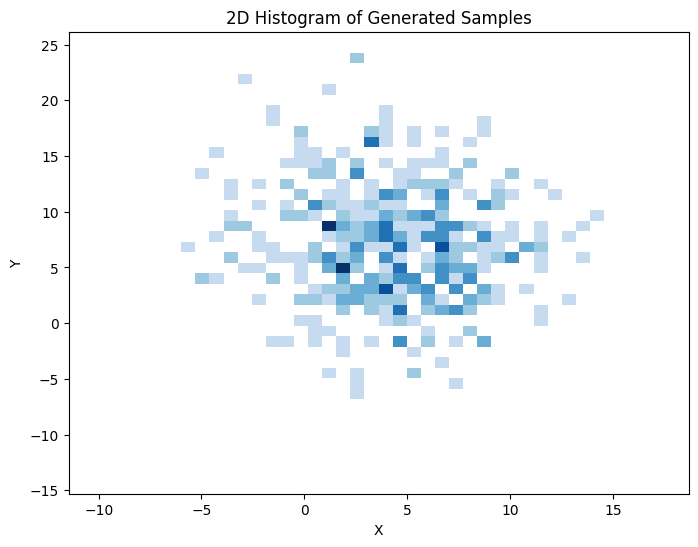

Sample Mean:
[4.29044859 7.13492085]
Sample Covariance Matrix:
[[20.41458038 -3.18239216]
 [-3.18239216 39.80021628]]


In [12]:
import seaborn as sns

#задание параметров
mu = np.array([4, 7])
Sigma = np.array([[20, -4], [-4, 40]])

#метод Бокса-Мюллера для генерации двумерных нормальных случайных чисел
n = 1000
u1, u2 = np.random.rand(2, n)
#преобразование Бокса-Мюллера
r = np.sqrt(-2 * np.log(u1))
theta = 2 * np.pi * u2
x = r * np.cos(theta)
y = r * np.sin(theta)

#объединяем 2 массива в матрицу
Z = np.vstack((x, y))

#преобразуем стандартное нормальное распределение в целевое
A = np.linalg.cholesky(Sigma)
X = A @ Z + mu[:, np.newaxis]

#построение гистограммы
plt.figure(figsize=(8, 6))
sns.histplot(x=X[0], y=X[1], bins=40, pthresh=0.1, cmap='Blues')
plt.xlabel("X")
plt.ylabel("Y")
plt.title("2D Histogram of Generated Samples")
plt.show()

#оценка выборочного среднего и ковариационной матрицы
sample_mean = np.mean(X, axis=1)
sample_cov = np.cov(X)

print("Sample Mean:")
print(sample_mean)
print("Sample Covariance Matrix:")
print(sample_cov)

### Problem 10*

Implement a method of generating a random partition of an n-element set into subsets. Use it to estimate the expected number of subsets in a random partition of a set of 100 elements.

Hint 1: Ширяев, Вероятность, т1, задача 2 к параграфу 1.

Hint 2: http://djalil.chafai.net/blog/2012/05/03/generating-uniform-random-partitions/

In [14]:
#функция для генерации случайного разбиения множества из n элементов
def random_partition(n):
    subsets = []
    for i in range(n):
        if subsets and np.random.rand() > 0.5:                 #с вероятностью 0.5 (если список subset не пуст) эл-т добавляется в существующее подмн-во
            chosen_subset = np.random.choice(len(subsets))     #это подмн-во выбирается случайно
            subsets[chosen_subset].append(i)
        else:                                                  #создается новое подмн-во, куда добавляется элемент
            subsets.append([i])
    return subsets

#функция для оценки матожидания числа подмножеств
def estimate_expected_subsets(n, trials=10000):
    subset_counts = [len(random_partition(n)) for _ in range(trials)]
    return np.mean(subset_counts)

#запускаем расчет для множества из 100 элементов с 5000 итерациями
expected_subsets_100 = estimate_expected_subsets(100, trials=5000)
expected_subsets_100

50.4634